# Virksomhedsnavn --> Branche
Denne notesbog gennemgår hvordan man ud fra data fra CVR og med hjælp fra Machine Learning (ML), kan anbefale en branche ud fra virksomhedens navn.

## Indhold
1. [Input](#Input)
2. [Machine Learning](#Machine Learning)
3. [Output](#Output)

In [84]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
#from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.externals import joblib
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import DanishStemmer

In [85]:
# Henter danske stopord
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andersbarfod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Input

In [86]:
# Henter virksomhedsdata og fjerne rækker som mangler værdier
cvr = pd.read_csv('data/cvr.csv').dropna(axis=0)

In [87]:
rank = cvr.groupby('hovedbranche_tekst') \
    .count() \
    .sort_values(by=['navn_tekst'], ascending=False) \
    .head(100)['hovedbranche_kode']

In [88]:
rank.head(10)

hovedbranche_tekst
Andre organisationer og foreninger i.a.n.                          88306
Ikke-finansielle holdingselskaber                                  56065
Uoplyst                                                            43411
Udlejning af erhvervsejendomme                                     30719
Virksomhedsrådgivning og anden rådgivning om driftsledelse         21036
Dyrkning af korn (undtagen ris), bælgfrugter og olieholdige frø    20073
Konsulentbistand vedrørende informationsteknologi                  13338
Tømrer- og bygningssnedkervirksomhed                               13257
Computerprogrammering                                              10865
Sundhedsvæsen i øvrigt i.a.n.                                       9820
Name: hovedbranche_kode, dtype: int64

Histogram over brancher

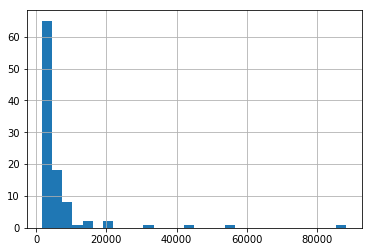

In [89]:
% matplotlib inline
rank.hist(bins=30)

Frasorterer de 6 største branchekoder da de vil skævvride modellen.

In [90]:
cvr = cvr[~cvr['hovedbranche_kode'].isin([949900,642020,999999, 682040, 702200, 11100])]

# Machine Learning
Nu er data klar til at blive kørt igennem af ML-algoritmer 

### Tekstprocessering
For at ensrette og reducere kompleksiteten i virksomhedsnavnene behandles teksten så stopord fjernes og ordstammen bestemmes.

In [91]:
stopwords = stopwords.words('danish')

In [92]:
stemmer = DanishStemmer()

In [93]:
def text_process(name):
    """
    Tekstprocessering som laver om til små bogstaver, fjerner stopord og finder ordstammen
    """
    lst = name.lower().split(' ')
    stop = [word for word in lst if word not in stopwords]
    stem = [stemmer.stem(word) for word in stop]
    
    return stem

### Træn, test og verificer modellen

Datasættet opdeles i træning (70%) og test (30%)

In [94]:
navn_train, navn_test, branche_train, branche_test = \
train_test_split(cvr['navn_tekst'], cvr['hovedbranche_tekst'], test_size=0.3)

Der oprettes pipeline som sørger for de forskellige skridt i modeltræningen

In [95]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

Modellen tilpasses data

In [96]:
pipeline.fit(navn_train,branche_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x177aad840>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [97]:
predictions = pipeline.predict(navn_test)

Laver rapport som viser hvor godt modellen klarer sig i forhold til test datasættet.

In [98]:
print(classification_report(predictions,branche_test))

                                                                                                                  precision    recall  f1-score   support

                                                                 Administration af fast ejendom på kontraktbasis       0.17      0.67      0.27       180
                                                                  Administration af og bidrag til erhvervsfremme       0.00      0.00      0.00         0
                Administration af sundhedsvæsen, undervisning, kultur og sociale forhold undtagen social sikring       0.01      1.00      0.02         2
                                                                             Agenturhandel med blandet sortiment       0.00      0.00      0.00         0
                             Agenturhandel med brændstoffer, malme, metaller og kemiske produkter til industrien       0.00      0.00      0.00         0
                             Agenturhandel med landbrugsråvarer, levende dy

/Users/andersbarfod/Documents/python/pydata/Notebooks/erhvervsstyrelsen/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Funnktion til at anbefale en branche

In [99]:
def predict_business(name):
    return pipeline.predict([name])[0]

# Output

Herunder kan den trænede model nu bruges til at anbefale en brache

In [100]:
predict_business('karsten dahl og sønner aps')

'Tømrer- og bygningssnedkervirksomhed'

Gemmer pipline objektet så det kan bruge i webapp

In [71]:
#joblib.dump(pipeline, 'model/predict_business.pkl')